# Group 35 Project Report

## Introduction

Heart disease is a very general term that describes a range of conditions that are often very detrimental to one's health. A main concern for many forms of heart disease is the narrowing of vessels, which leads to higher risk of blockages, and therefore death. There are many contributers to the presence of heart disease in a person, including sex, age, cholesterol levels, heart rate, and blood pressure. As one gets older, the heart may begin to weaken and the vessels may narrow. A build-up of cholesterol on the vessel walls also narrows the vessels, and high blood pressure can harden and/or thicken the vessel walls, causing them to narrow.

The data below has been collected from 294 different patients and reports on specific aspects of their health with the purpose of determining the presence of heart disease. Similar data has been collected from hospitals  in Cleveland, Hungary, Switzerland, and the VA Long Beach. The data we are working with contains 14 variables/columns, and is taken from the Hungarian Institute of Cardiology in Budapest. 

The question to be answered is: Is heart disease in a patient based on their age, resting blood pressure, cholesteral levels, and maximum heart rate?

## Data Analysis

To predict whether the patient has heart disease, we will be using KNN classification. We will read in, clean, and wrangle the data, then split it into a training set to tune the model, and a testing set to see how well the model works. We will then summarize the data, and create visualizations to show the relationship between the variables and the diagnosis. 

In [1]:
# Load package
library(tidyverse)
library(tidymodels)
library(digest)
library(GGally)
library(repr)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Read in the heart disease data, rename the column name and mutate all columns to be numeric
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"
heart_disease <- read_delim(url, delim = " ", col_names = FALSE) %>%
                    rename(age = X1, sex = X2, chest_pain_type = X3, resting_BP = X4, cholesterol = X5, fasting_bs = X6, rest_ecg = X7,
                           max_hr = X8, ex_angina = X9, st_depression = X10, slope_st = X11, num_major_vessels = X12, thal = X13, diagnosis = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_double()
)



In [3]:
# Mutate the age, resting_BP, cholesteral, and max_hr to be integer
heart_disease <- heart_disease %>%
                mutate(age = as.integer(age))%>%
                mutate(resting_BP = as.integer(resting_BP))%>%
                mutate(cholesterol = as.integer(cholesterol))%>%
                mutate(max_hr = as.integer(max_hr))

# Replace all "-9" as NA
heart_disease <- heart_disease %>%
                 mutate(across(where(is.numeric), ~na_if(., -9)))

# Select age, resting_BP, cholesteral, and mx_hr columns, remove any rows that contain NA
heart_disease <- heart_disease %>%
                    select(age, resting_BP, cholesterol, max_hr, diagnosis) %>%
                    na.omit() 

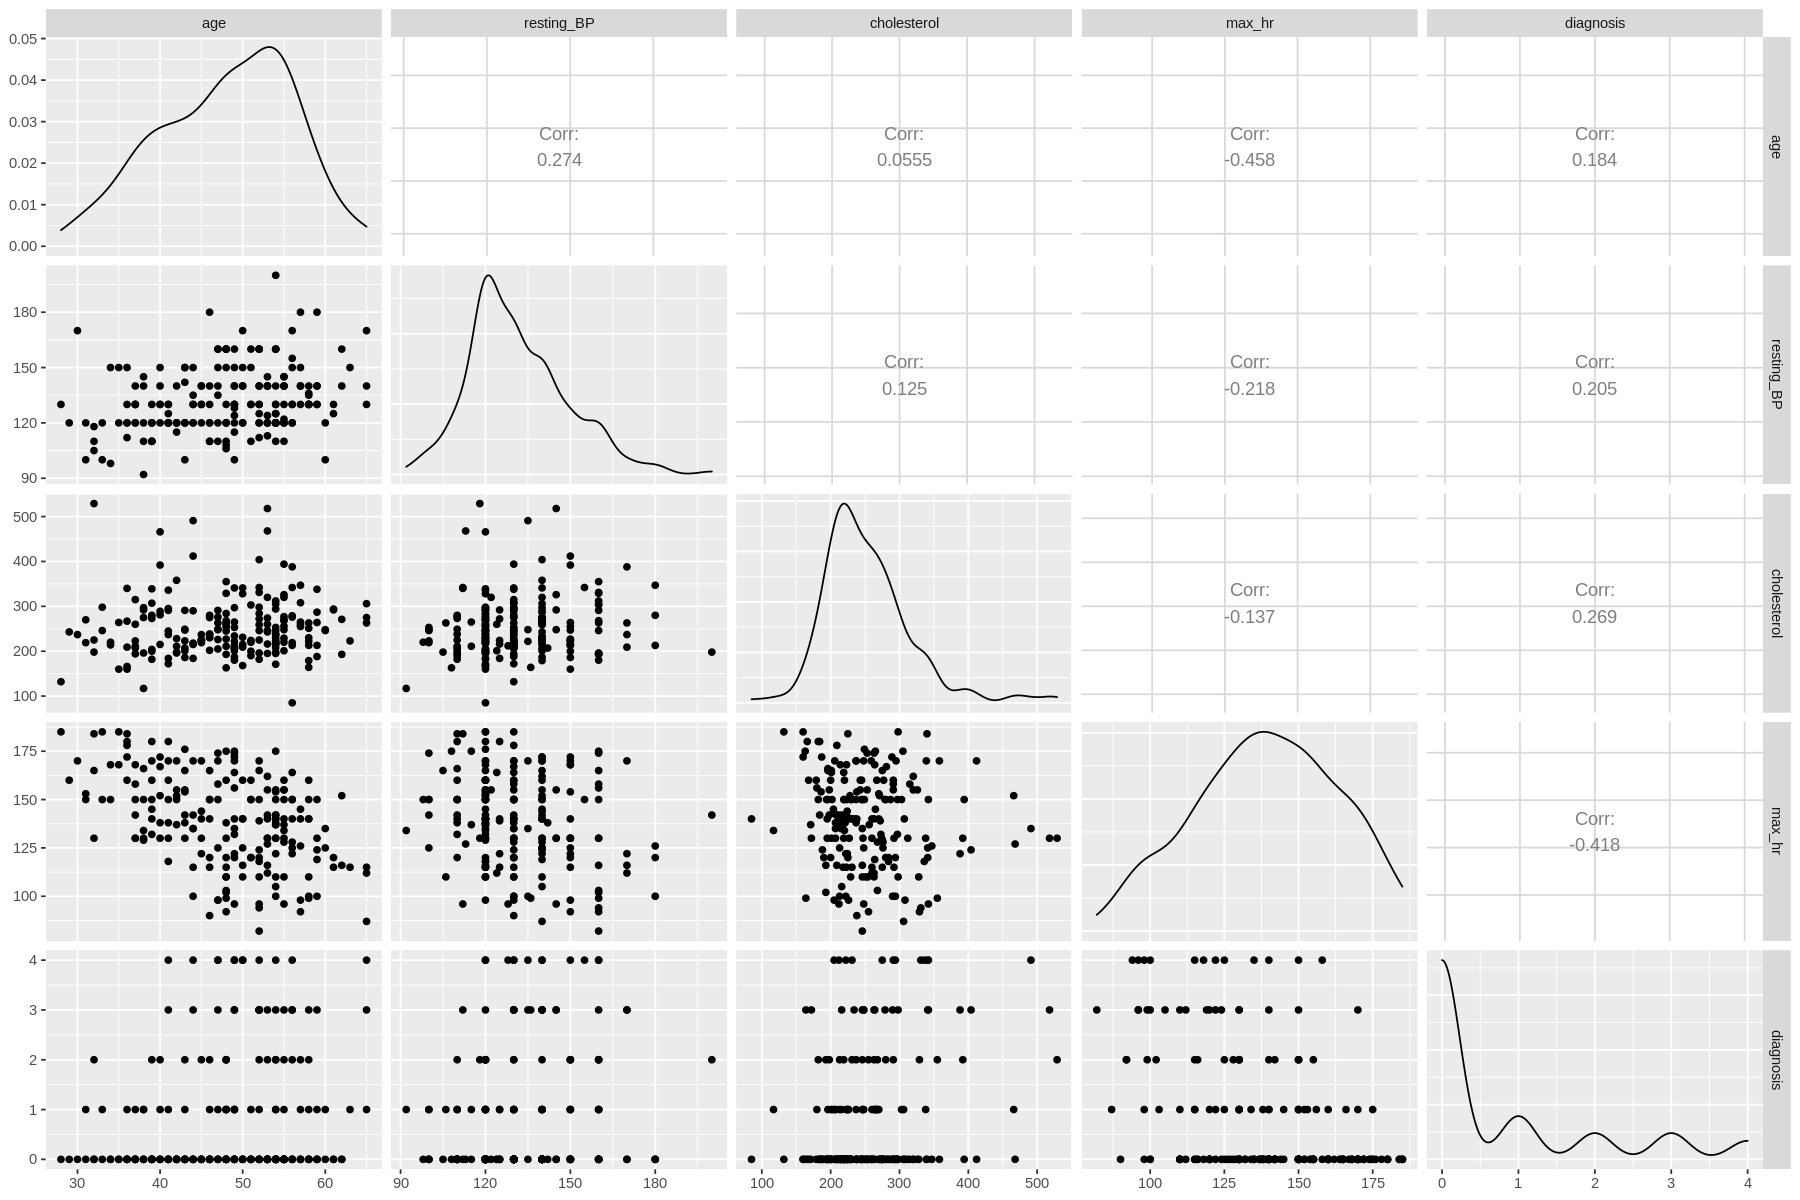

In [4]:
# Set the seed
set.seed(999) 

# Split data and create a training set (only use to create ggpairs scatterplot)
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = diagnosis)
heart_disease_train_ggpairs <- training(heart_disease_split)

# Create a ggpairs scatterplot of all the columns we are interested in including in our model
options(repr.plot.width = 15, repr.plot.height = 10)
heart_disease_eda <- ggpairs(heart_disease_train_ggpairs)
heart_disease_eda

In [5]:
# Mutate the diagnosis to be factors and replace "1","2","3","4" as "1"
heart_disease_data <- heart_disease %>% 
                    mutate(diagnosis = as.factor(diagnosis))%>%
                    mutate(diagnosis = replace(diagnosis, diagnosis != "0", "1"))

heart_disease_data

age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
48,110,211,138,0
47,140,257,135,0
53,130,182,148,0


In [6]:
# Set the seed
set.seed(999) 

# Split the data into a training and test set

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

In [7]:
# Group by diagnosis and find average age, resting blood pressure, cholesteral and maximum heart rate achieved, 
# the number of observations, and percentage of participants in each group

heart_disease_train_table <- heart_disease_train %>%
                                select(age,resting_BP, max_hr, cholesterol, diagnosis)%>%
                                group_by(diagnosis)%>%
                                summarize(avg_age = round(mean(age), digits = 1),
                                          avg_resting_BP = round(mean(resting_BP),digits = 1),
                                          avg_max_hr = round(mean(max_hr),digits = 1),
                                          avg_cholesteral = round(mean(cholesterol),digits = 1),
                                          num_obs = n(),
                                          percentage = round(n()/ nrow(heart_disease_train)*100,digits = 1))

heart_disease_train_table

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,avg_age,avg_resting_BP,avg_max_hr,avg_cholesteral,num_obs,percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0,47.4,131.1,145.1,233.7,127,62.6
1,49.1,134.8,131.9,270.3,76,37.4


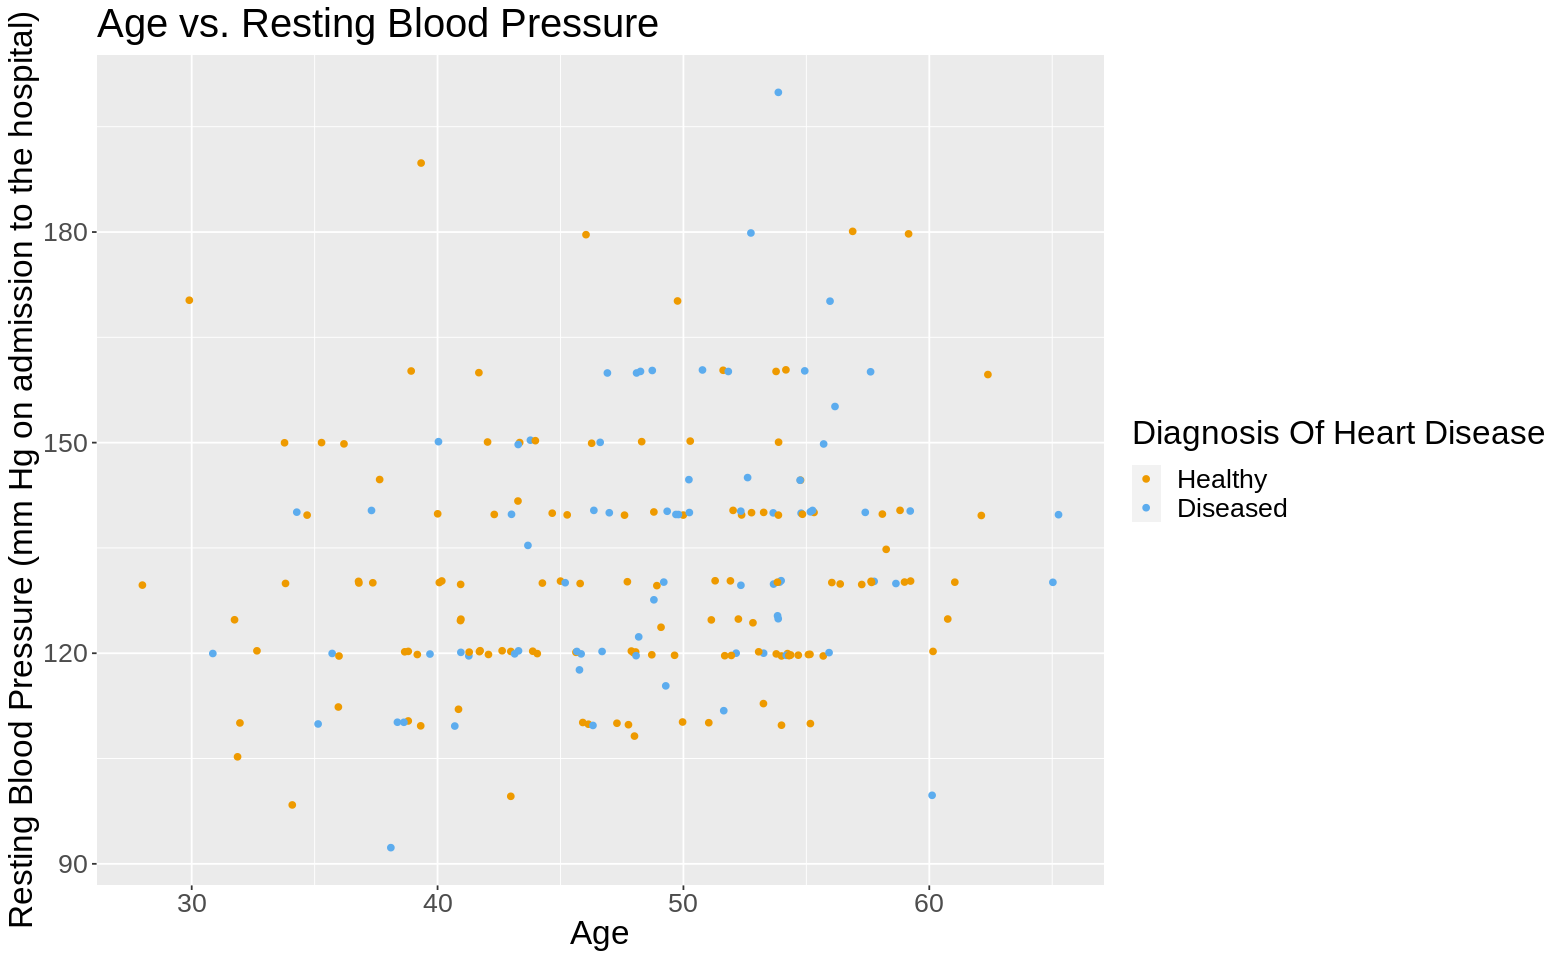

In [8]:
# Plot for age vs. resting blood pressure

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = resting_BP, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Resting Blood Pressure (mm Hg on admission to the hospital)", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Resting Blood Pressure")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Diseased"), values = c("orange2", "steelblue2"))
resting_BP_plot

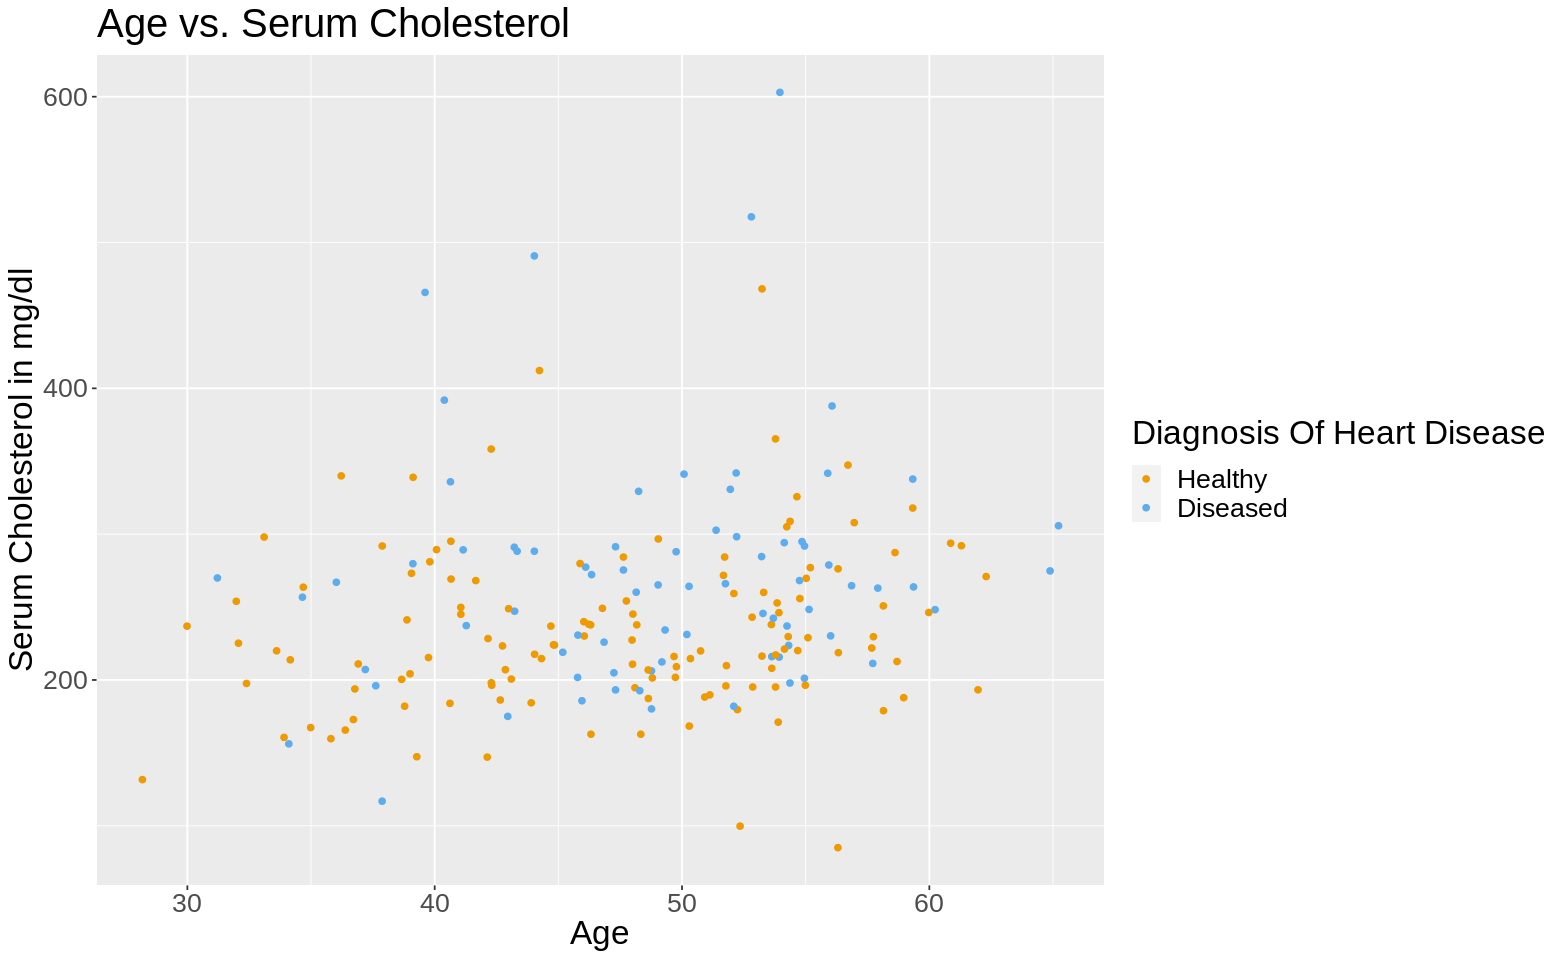

In [9]:
# Plot for age vs. cholesteral

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = cholesterol, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Serum Cholesterol in mg/dl", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Serum Cholesterol")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Diseased"), values = c("orange2", "steelblue2"))
resting_BP_plot

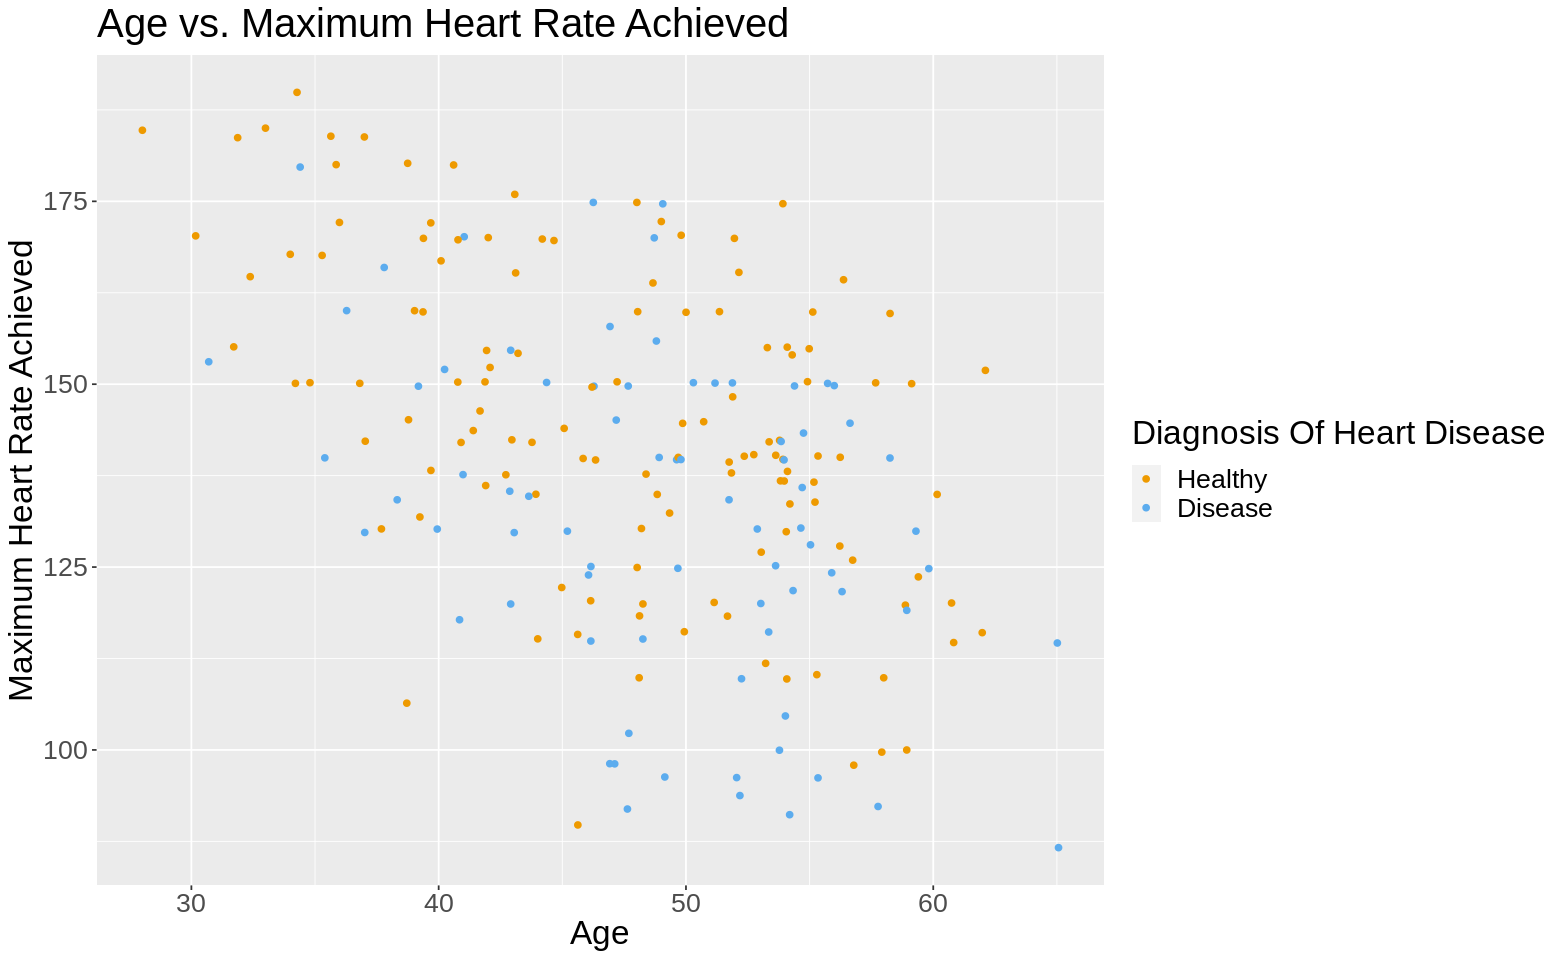

In [10]:
# Plot for age vs. maximum heart rate achieved

options(repr.plot.width = 13, repr.plot.height = 8)

max_hr_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = max_hr, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Maximum Heart Rate Achieved")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)+
                    scale_color_manual(labels = c("Healthy", "Disease"), values = c("orange2", "steelblue2"))
max_hr_plot

## KNN Classification

### Using one predictor to predict a diagnosis

### Age

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



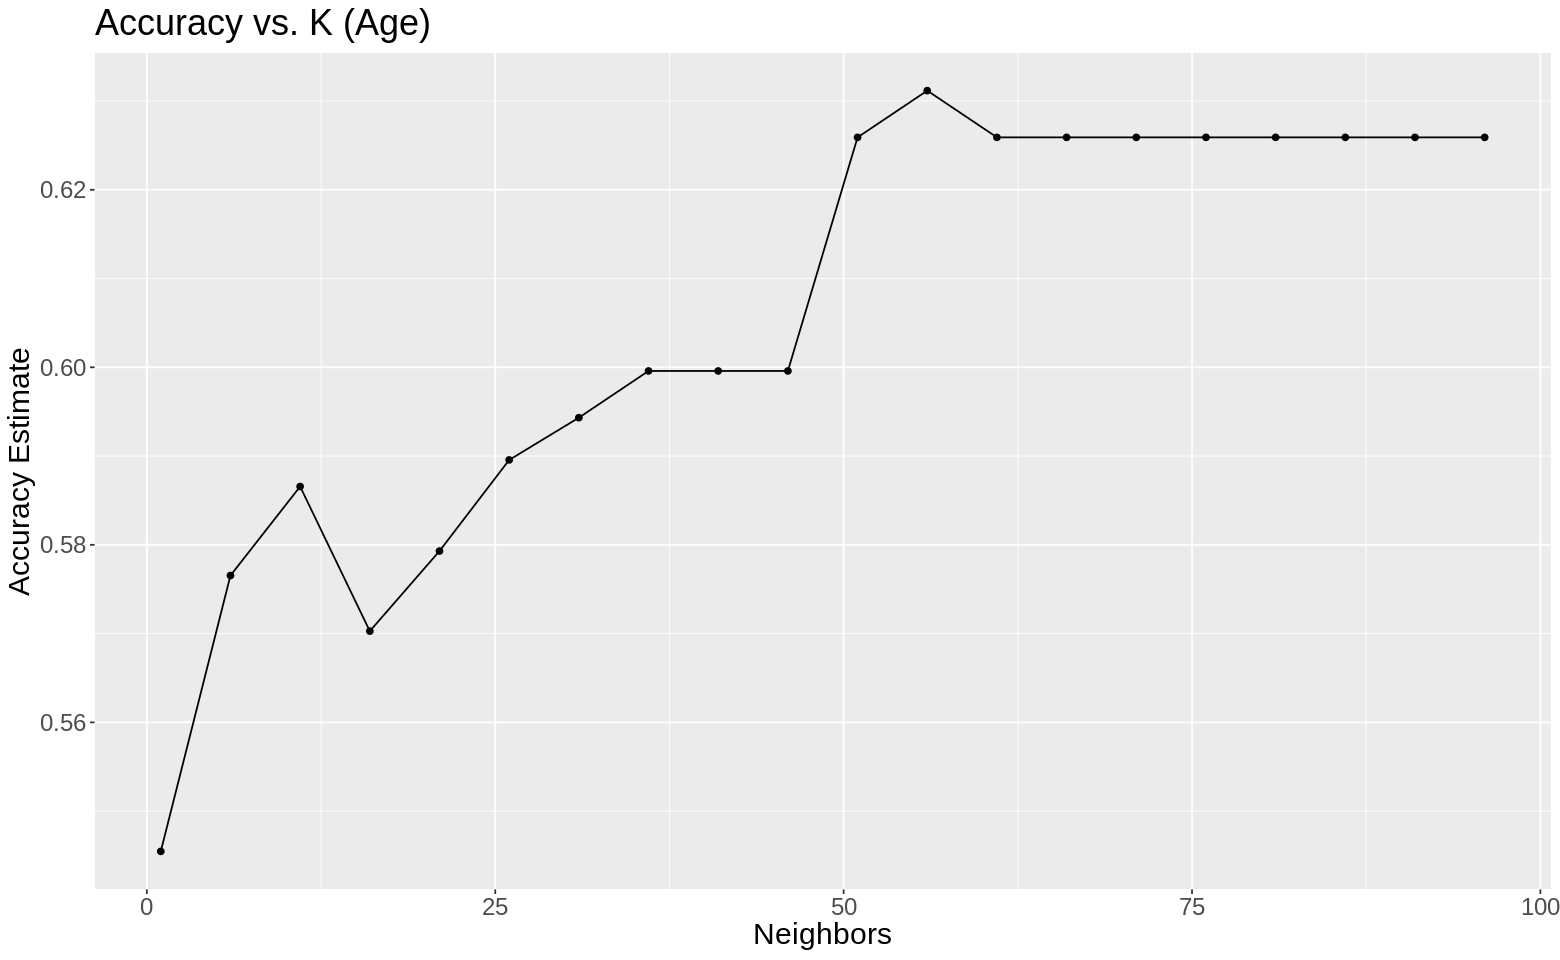

In [11]:
# Set the seed
set.seed(100) 

# Create the standardization recipe
heart_disease_recipe_one <- recipe(diagnosis ~ age, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_one <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_one <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

# Put the recipe and model specification in a workflow
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results_one <- workflow() %>%
            add_recipe(heart_disease_recipe_one)%>%
            add_model(knn_spec_one) %>%
            tune_grid(resamples = heart_disease_vfold_one, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_one <- knn_results_one %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_one <- ggplot(accuracies_one, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age)")
accuracy_vs_k_one

In [12]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_one <- nearest_neighbor(weight_func = "rectangular", neighbors = 55) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_one <- workflow() %>%
            add_recipe(heart_disease_recipe_one)%>%
            add_model(knn_spec_one) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_one <- predict(knn_fit_one, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_one <- heart_disease_test_predictions_one %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_one

# Create a summary dataframe
summary_table_1 <- heart_disease_accuracy_one %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "one predictor", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6268657


### Using two predictors to predict a diagnosis

### Age and Resting Blood Pressure

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



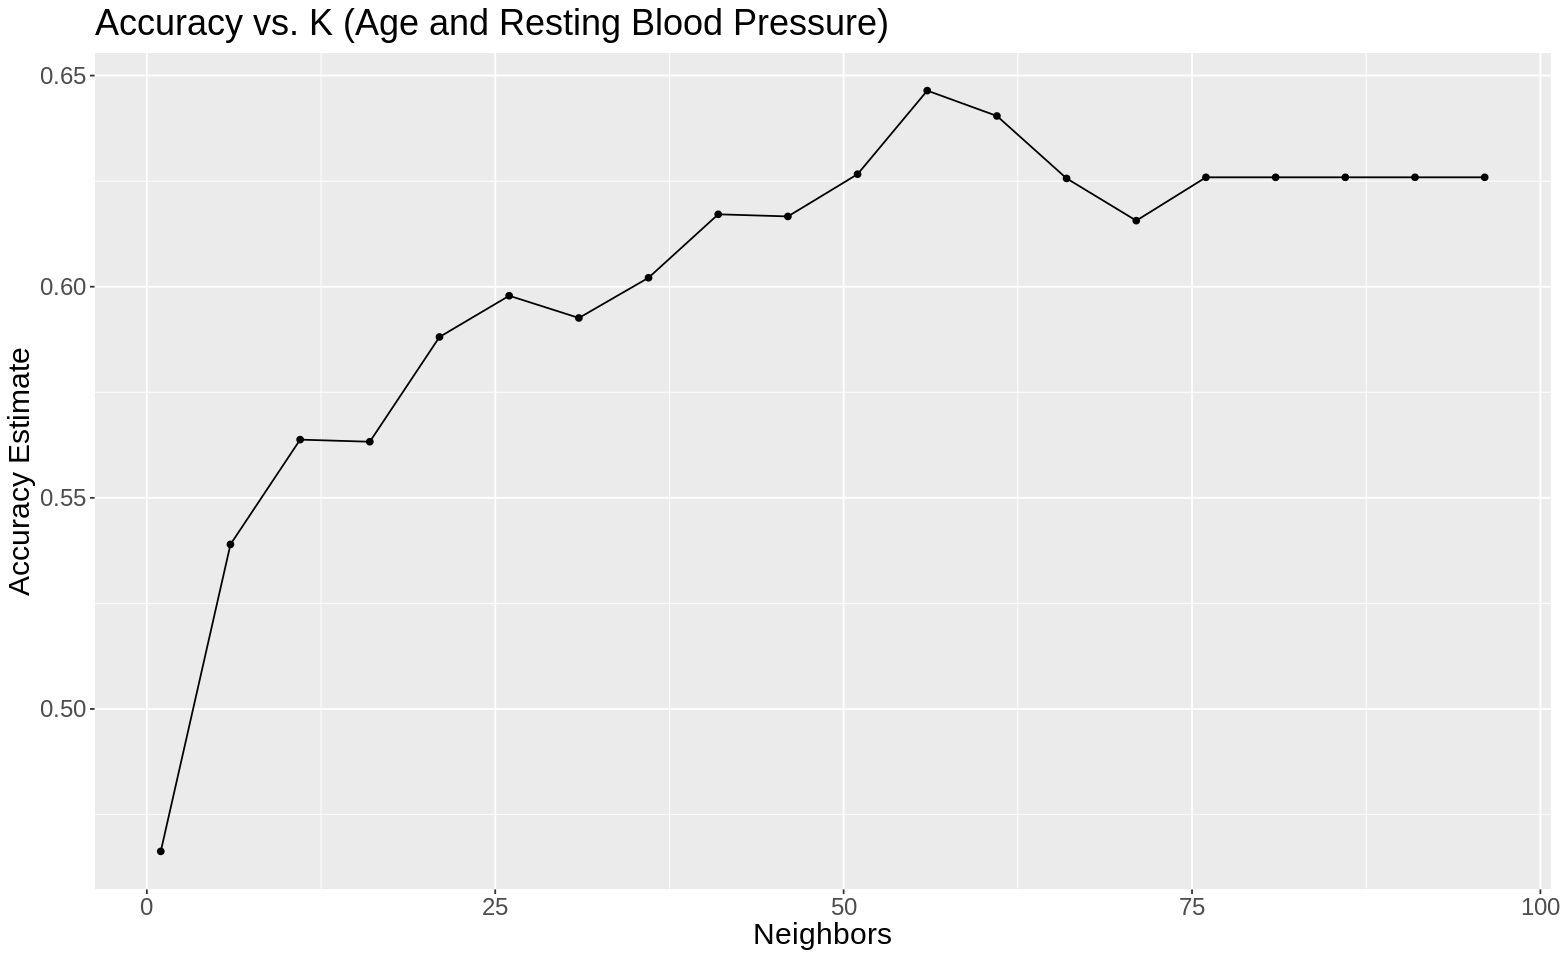

In [13]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
heart_disease_recipe_two_1 <- recipe(diagnosis ~ age + resting_BP, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_two_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_two_1 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_two_1 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_1)%>%
            add_model(knn_spec_two_1) %>%
            tune_grid(resamples = heart_disease_vfold_two_1, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_two_1 <- knn_results_two_1 %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_two_1 <- ggplot(accuracies_two_1, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Resting Blood Pressure)")
accuracy_vs_k_two_1

In [14]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_two_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 55) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_two_1 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_1)%>%
            add_model(knn_spec_two_1) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_two_1 <- predict(knn_fit_two_1, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_two_1 <- heart_disease_test_predictions_two_1 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_two_1

# Create a summary dataframe
summary_table_2.1 <- heart_disease_accuracy_two_1 %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "two predictors (age and resting_BP)", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6567164


### Age and Cholesterol

In [15]:
# Set the seed
set.seed(100) 

# Create the standardization recipe
heart_disease_recipe_two_2 <- recipe(diagnosis ~ age + cholesterol, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_two_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_two_2 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_two_2 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_2)%>%
            add_model(knn_spec_two_2) %>%
            tune_grid(resamples = heart_disease_vfold_two_2, grid = k_vals) %>%
            collect_metrics()

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



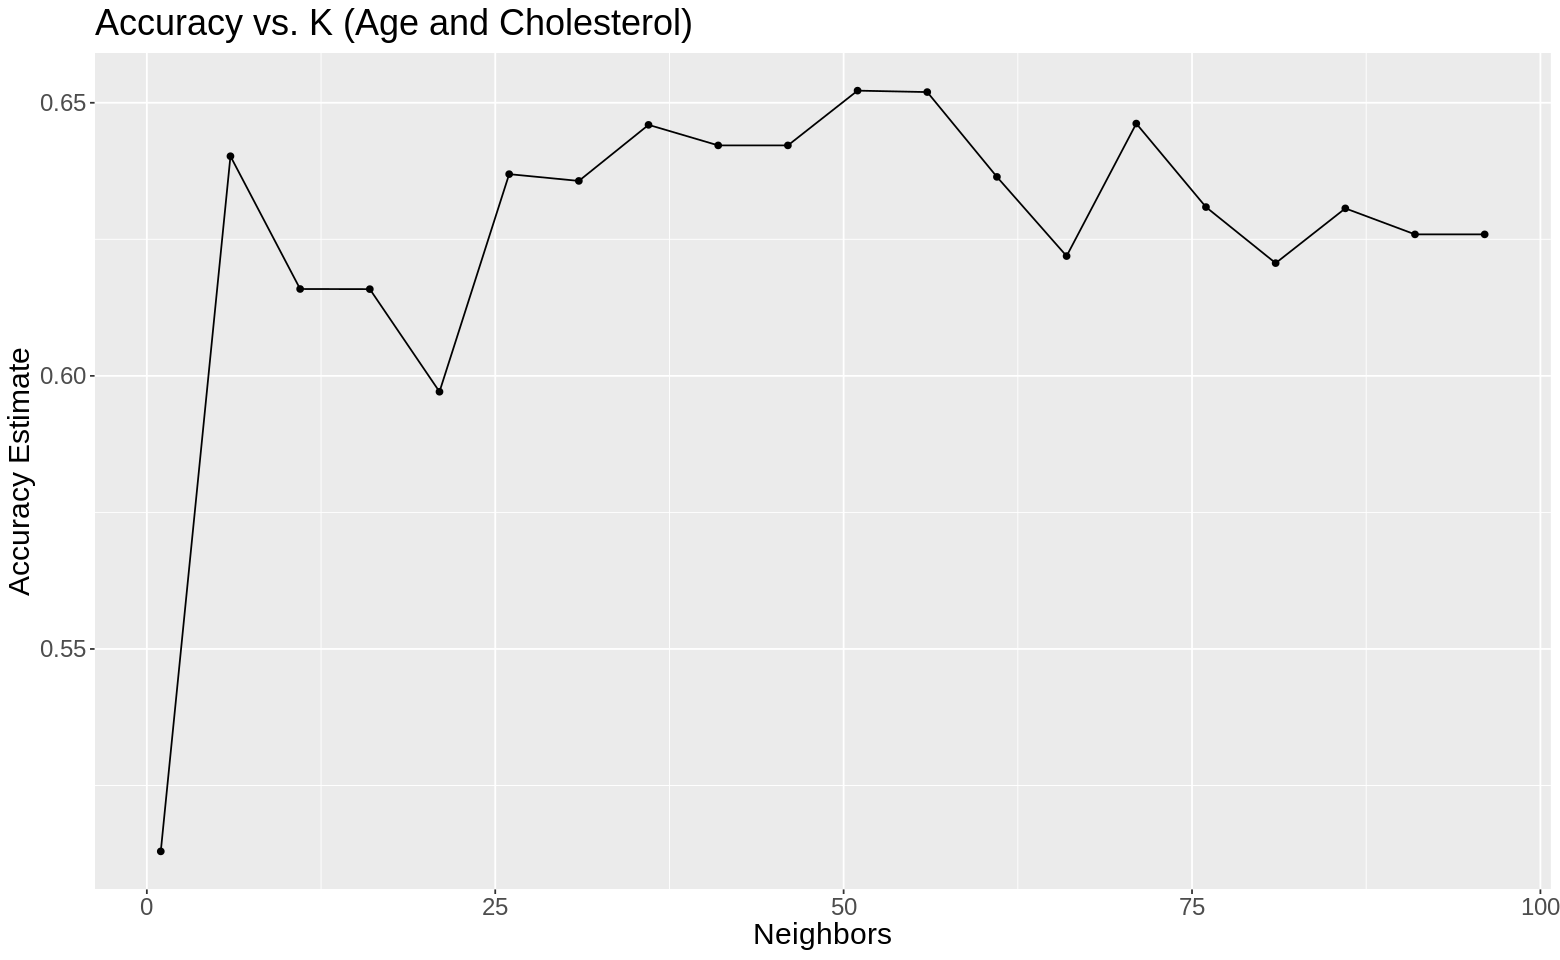

In [16]:
# Filter for accuracy from the .metric column
accuracies_two_2 <- knn_results_two_2 %>% 
       filter(.metric == "accuracy")

# Select K by plotting Accuracy vs. K

accuracy_vs_k_two_2 <- ggplot(accuracies_two_2, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Cholesterol)")
accuracy_vs_k_two_2

In [17]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_two_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 54) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_two_2 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_2)%>%
            add_model(knn_spec_two_2) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_two_2 <- predict(knn_fit_two_2, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_two_2 <- heart_disease_test_predictions_two_2 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_two_2

# Create a summary dataframe
summary_table_2.2 <- heart_disease_accuracy_two_2 %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "two predictors (age and cholesterol)", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6119403


### Age and Maximum Heart Rate Achieved

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



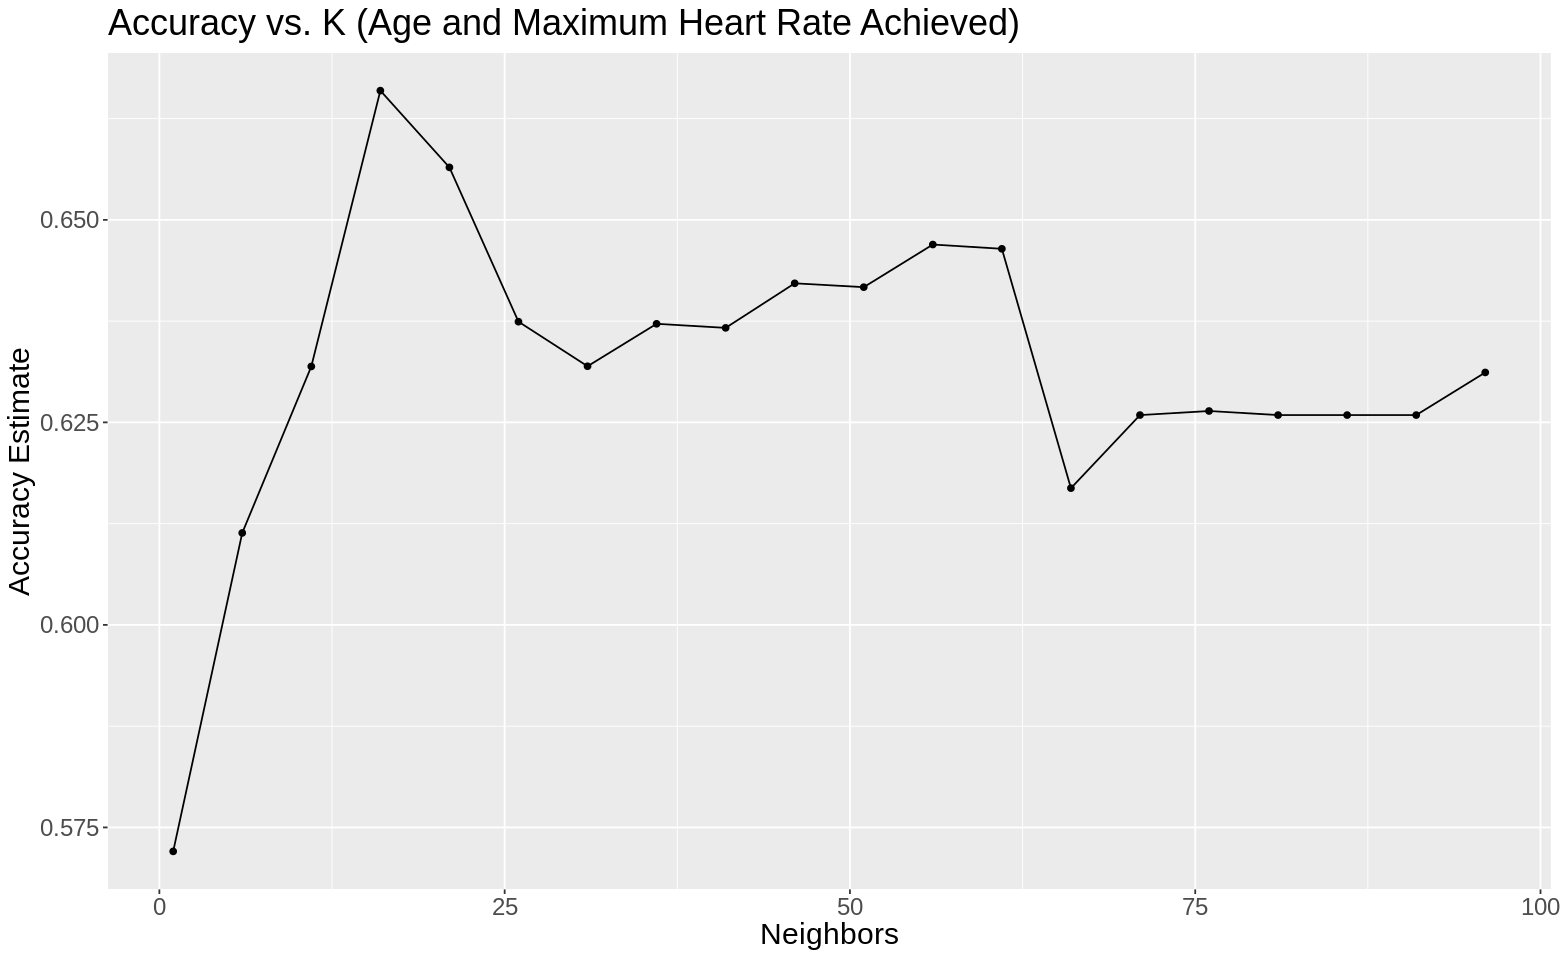

In [18]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
heart_disease_recipe_two_3 <- recipe(diagnosis ~ age + max_hr, data = heart_disease_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

# Create the KNN model specification
knn_spec_two_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_two_3 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_two_3 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_3)%>%
            add_model(knn_spec_two_3) %>%
            tune_grid(resamples = heart_disease_vfold_two_3, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_two_3 <- knn_results_two_3 %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_two_3 <- ggplot(accuracies_two_3, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Age and Maximum Heart Rate Achieved)")
accuracy_vs_k_two_3

In [19]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_two_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_two_3 <- workflow() %>%
            add_recipe(heart_disease_recipe_two_3)%>%
            add_model(knn_spec_two_3) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_two_3 <- predict(knn_fit_two_3, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_two_3 <- heart_disease_test_predictions_two_3 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_two_3

# Create a summary dataframe
summary_table_2.3 <- heart_disease_accuracy_two_3 %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "two predictors (age and max_hr)", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6716418


### Using three predictors to predict a diagnosis

### Age, Resting Blood Pressure, and Maximum Heart Rate Achieved

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



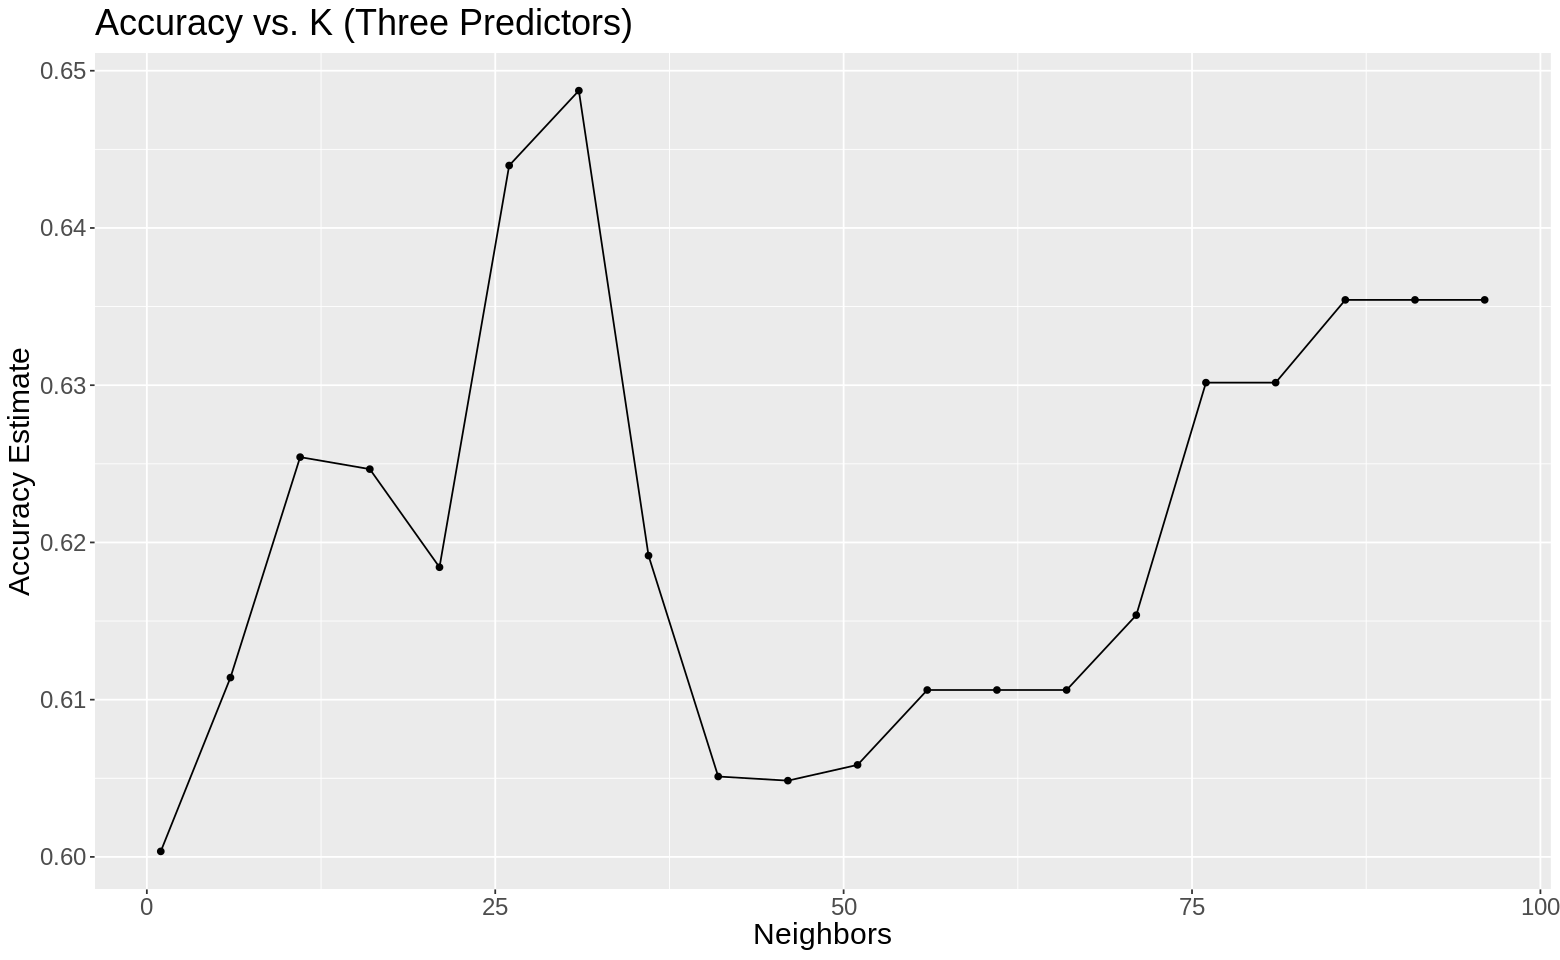

In [20]:
# Set the seed
set.seed(100) 

# Create the standardization recipe
three_predictors_recipe_1 <- recipe(diagnosis ~ age + max_hr + resting_BP, data = heart_disease_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())

# Create the KNN model specification
knn_spec_three_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_three_1 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_three_1 <- workflow() %>%
            add_recipe(three_predictors_recipe_1)%>%
            add_model(knn_spec_three_1) %>%
            tune_grid(resamples = heart_disease_vfold_three_1, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_three_1 <- knn_results_three_1  %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K
accuracy_vs_k_three_1 <- ggplot(accuracies_three_1, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Three Predictors)")
accuracy_vs_k_three_1 

In [21]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_three_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 29) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_three_1 <- workflow() %>%
            add_recipe(three_predictors_recipe_1)%>%
            add_model(knn_spec_three_1) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_three_1 <- predict(knn_fit_three_1, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_three_1 <- heart_disease_test_predictions_three_1 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_three_1

# Create a summary dataframe
summary_table_3.1 <- heart_disease_accuracy_three_1 %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "three predictors (except cholesterol)", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6865672


### Resting Blood Pressure, Cholesterol, and Maximum Heart Rate Achieved

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



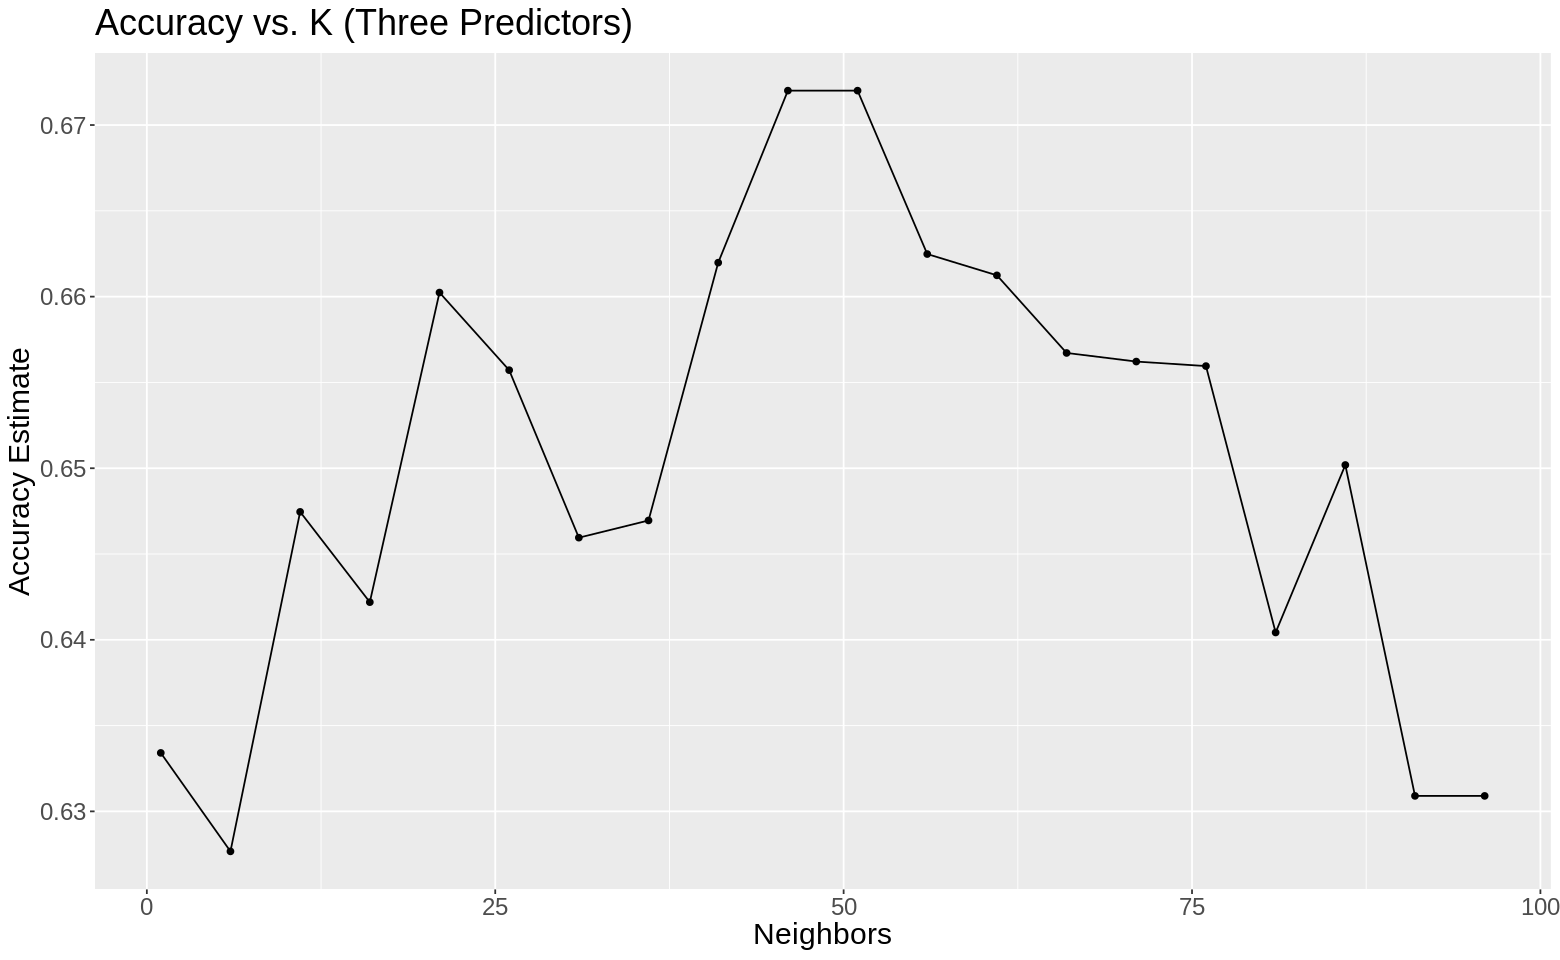

In [22]:
# Set the seed
set.seed(999) 

# Create the standardization recipe
three_predictors_recipe_2 <- recipe(diagnosis ~ max_hr + resting_BP + cholesterol, data = heart_disease_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())
# Create the KNN model specification
knn_spec_three_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_three_2 <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_three_2 <- workflow() %>%
            add_recipe(three_predictors_recipe_2)%>%
            add_model(knn_spec_three_2) %>%
            tune_grid(resamples = heart_disease_vfold_three_2, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_three_2 <- knn_results_three_2  %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K
accuracy_vs_k_three_2  <- ggplot(accuracies_three_2, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (Three Predictors)")
accuracy_vs_k_three_2

In [23]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_three_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 50) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_three_2 <- workflow() %>%
            add_recipe(three_predictors_recipe_2)%>%
            add_model(knn_spec_three_2) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_three_2 <- predict(knn_fit_three_2, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_three_2 <- heart_disease_test_predictions_three_2 %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_three_2

# Create a summary dataframe
summary_table_3.2 <- heart_disease_accuracy_three_2 %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "three predictors (except age)", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7462687


### Using all predictors to predict a diagnosis

### Age, Resting Blood Pressure, Cholesterol, and Maximum Heart Rate Achieved

! Fold01: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold02: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold03: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold04: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold05: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold06: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold07: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold08: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold09: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold10: internal: No observations were detected in `truth` for level(s): '2', '3...



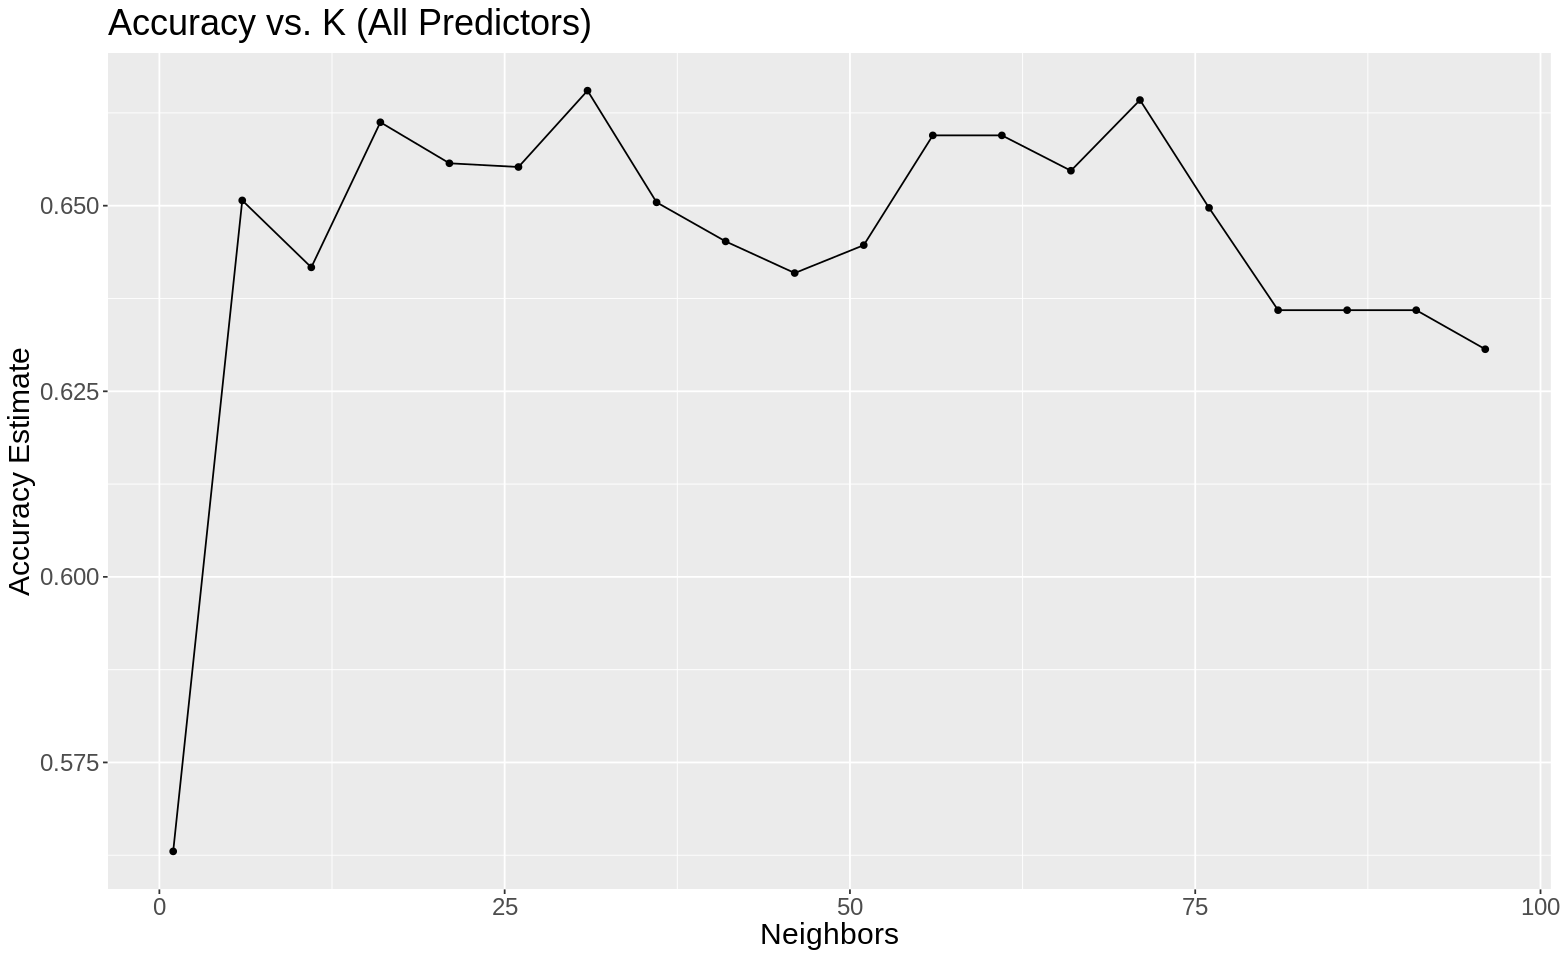

In [24]:
# Set the seed
set.seed(100) 

# Create the standardization recipe
all_predictors_recipe <- recipe(diagnosis ~ age + max_hr + resting_BP + cholesterol, data = heart_disease_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())

# Create the KNN model specification
knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification")

# Perform 10-fold cross-validation
heart_disease_vfold_all <- vfold_cv(heart_disease_train, v = 10, strata = diagnosis)

knn_results_all <- workflow() %>%
            add_recipe(all_predictors_recipe)%>%
            add_model(knn_spec_all) %>%
            tune_grid(resamples = heart_disease_vfold_all, grid = k_vals) %>%
            collect_metrics()

# Filter for accuracy from the .metric column
accuracies_all <- knn_results_all  %>% 
       filter(.metric == "accuracy")


# Select K by plotting Accuracy vs. K

accuracy_vs_k_all  <- ggplot(accuracies_all, aes(x = neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x = "Neighbors", y = "Accuracy Estimate")+
                    theme(text = element_text(size = 18))+
                    ggtitle("Accuracy vs. K (All Predictors)")
accuracy_vs_k_all

In [25]:
# Make a new model specification for the best paramter value and retrain the classifier using the fit function.
knn_spec_all <- nearest_neighbor(weight_func = "rectangular", neighbors = 29) %>%
                set_engine("kknn") %>%
                set_mode("classification")

knn_fit_all <- workflow() %>%
            add_recipe(all_predictors_recipe)%>%
            add_model(knn_spec_all) %>%
            fit(data = heart_disease_train)

# Predict the labels in the test set
heart_disease_test_predictions_all <- predict(knn_fit_all, heart_disease_test) %>%
                                    bind_cols(heart_disease_test)

# Compute the accuracy
heart_disease_accuracy_all <- heart_disease_test_predictions_all %>%
                            metrics(truth = diagnosis, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
heart_disease_accuracy_all

# Create a summary dataframe
summary_table_all <- heart_disease_accuracy_all %>%
                    select(.estimate) %>%
                    add_column(number_of_predictions = "all predictors", .before = ".estimate")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7164179


In [26]:
# Combine all summary dataframs into one
accuracies_summary <- rbind(summary_table_1, 
                            summary_table_2.1, summary_table_2.2, summary_table_2.3, 
                            summary_table_3.1, summary_table_3.2,
                            summary_table_all)

print(accuracies_summary)

# A tibble: 7 x 2
  number_of_predictions                 .estimate
  <chr>                                     <dbl>
1 one predictor                             0.627
2 two predictors (age and resting_BP)       0.657
3 two predictors (age and cholesterol)      0.612
4 two predictors (age and max_hr)           0.672
5 three predictors (except cholesterol)     0.687
6 three predictors (except age)             0.746
7 all predictors                            0.716


## Discussion

Summarize findings
is this what we expected?
impact these findings could have
future questions

## References

Wang, Xiaona, et al. “Correlation between Small and Dense Low‐Density Lipoprotein Cholesterol and Cardiovascular Events in Beijing Community Population.” The Journal of Clinical Hypertension, vol. 23, no. 2, 2021, pp. 345–351., https://doi.org/10.1111/jch.14150. 